In [1]:
from factor_tools import *

def get_positions(factor, start_date, end_date, group=5, freq='M'):
    """
    获取持仓
    params：
        factor：dataframe，index为date，columns为code，values为因子值
        start_date：开始时间
        end_date：结束时间
        group：第几组作为持仓组合
        freq：调仓频率，默认月频，根据因子频率来设定
    return：
        nav_df：策略和基准的净值数据
    """
    rebalance_dates = get_period_date(freq, start_date, end_date)
    rebalance_dates = [datetime.strptime(dt, '%Y-%m-%d') for dt in rebalance_dates]
    factor.index = pd.to_datetime(factor.index)
    factor = factor.stack().dropna()
    factor.name = 'factor'
    
    quantile_groups = bucketize_by_quantile(factor, group)
    portfolio_weights = get_portfolios_from_quantile_groups(quantile_groups, group)
    
    cum_list = []
    for start in rebalance_dates:
        weights = portfolio_weights[start]
        dat = [start]*len(weights)
        weights = pd.DataFrame(weights)
        weights['date'] = dat
        weights = weights.reset_index()
        weights.columns = ['code', 'factor', 'date']
        cum_list.append(weights)
        
    cum_df = pd.concat(cum_list)
    cum_df = cum_df.reset_index().drop(['index'], axis=1)
    
    factors = []
    names = []
    
    for dat, cod in zip(cum_df.date, cum_df.code):
        factors.append(factor.loc[dat, cod])
        name = get_all_securities(date=dat)[['display_name']]
        names.append(name.display_name[cod])
    cum_df.factor = factors
    cum_df['name'] = names
    
    cum_df = cum_df.set_index(['date', 'code'])
    return cum_df

def get_latest_position(file, last_date=True, date='2020-01-23', num=50):
    """
    获取某一期的持仓
    param：
        file：持仓文件
        last_date：日期是否最新
        date：持仓日期
        num：持股数目
    return：
        某一期的持仓
    """
    position = pd.read_csv(file, index_col='date')
    
    date = position.index[-1]
    position = position.loc[date].nlargest(num,'factor')
    
    return position

In [2]:
start_date = '2010-01-01'
end_date = '2020-12-31'
index_id = '000300.XSHG'

trade_month_list = get_period_date('M', start_date, end_date)
factor_pools = get_processed_cum_factor(trade_month_list, index_id)

In [3]:
univ = []
for date in trade_month_list:
    temp = get_index_univ(index_id, date)
    univ = list(set(univ + temp))
forward_return = get_forward_return(univ, trade_month_list, n=1)
forward_return = forward_return.pivot(index='date', columns='code', values='forward_return')

SN = factor_pools.pivot(index='date', columns='code', values='SN')
PN = factor_pools.pivot(index='date', columns='code', values='PN')
cfo_to_ev = factor_pools.pivot(index='date', columns='code', values='cfo_to_ev')
residual_volatility = factor_pools.pivot(index='date', columns='code', values='residual_volatility')
Skewness60 = factor_pools.pivot(index='date', columns='code', values='Skewness60')
Turnover60 = factor_pools.pivot(index='date', columns='code', values='Turnover60')
roe_ttm = factor_pools.pivot(index='date', columns='code', values='roe_ttm')
NNN = factor_pools.pivot(index='date', columns='code', values='NNN')
Skewness20 = factor_pools.pivot(index='date', columns='code', values='Skewness20')
gross_income_ratio = factor_pools.pivot(index='date', columns='code', values='gross_income_ratio')
pe_ratio = factor_pools.pivot(index='date', columns='code', values='pe_ratio')
pb_ratio = factor_pools.pivot(index='date', columns='code', values='pb_ratio')
inc_revenue_year_on_year = factor_pools.pivot(index='date', columns='code', values='inc_revenue_year_on_year')
inc_net_profit_year_on_year = factor_pools.pivot(index='date', columns='code', values='inc_net_profit_year_on_year')
inc_operation_profit_year_on_year = factor_pools.pivot(index='date', columns='code', values='inc_operation_profit_year_on_year')
Saavg = factor_pools.pivot(index='date', columns='code', values='Saavg')
sale_expense_to_operating_revenue = factor_pools.pivot(index='date', columns='code', values='sale_expense_to_operating_revenue')
PNN = factor_pools.pivot(index='date', columns='code', values='PNN')
RCGO = factor_pools.pivot(index='date', columns='code', values='RCGO')

fac_dict = {'经营活动产生的现金流量净额与企业价值之比TTM':cfo_to_ev,
                     '残差波动率':residual_volatility, 
                     '个股收益的60日偏度':Skewness60, 
                     '权益回报率TTM':roe_ttm,
                     '个股收益的20日偏度':Skewness20, 
                     '销售毛利率':gross_income_ratio, 
                     '市盈率（TTM）':pe_ratio, 
                     '市净率（TTM）':pb_ratio,
                     '单季度营业收入增长率（同比）':inc_revenue_year_on_year, 
                     '单季度净利润增长率（同比）':inc_net_profit_year_on_year,
                     '单季度营业利润增长率（同比）':inc_operation_profit_year_on_year,
                     '营业费用与营业总收入之比':sale_expense_to_operating_revenue,
                     'Saavg':Saavg,
                     'SN':SN,
                     'PN':PN,
                     'PNN':PNN,
                     'NNN':NNN,
                     '残差未实现收益':RCGO,
                     '60日平均换手率':Turnover60
                    }

fac_dict2 = { '经营活动产生的现金流量净额与企业价值之比TTM':cfo_to_ev,
                     '残差波动率':residual_volatility, 
                     '个股收益的60日偏度':Skewness60,  
                     '权益回报率TTM':roe_ttm, 
                     '个股收益的20日偏度':Skewness20, 
                     '销售毛利率':gross_income_ratio, 
                     '市盈率（TTM）':pe_ratio, 
                     '市净率（TTM）':pb_ratio,
                     '单季度营业收入增长率（同比）':inc_revenue_year_on_year, 
                     '单季度净利润增长率（同比）':inc_net_profit_year_on_year,
                     '单季度营业利润增长率（同比）':inc_operation_profit_year_on_year, 
                     '营业费用与营业总收入之比':sale_expense_to_operating_revenue,
                    }

In [ ]:
eq_factor = equal_weight(fac_dict)
daily_returns = get_daily_return(univ, start_date, end_date)
daily_returns.index = pd.to_datetime(daily_returns.index)

In [4]:
def bucketize_by_quantile(factor, quantiles=10):
    """
    因子分组
    params：
        factor：series，index为date，code，values为因子值
        quantiles：分组数目
    """
    quantile_labels = list(range(1, quantiles + 1))
    quantile_groups = (factor
                       .groupby(level='date', group_keys=False)
                       .apply(pd.qcut,
                              q=quantiles,
                              labels=quantile_labels))
    return quantile_groups


def get_portfolios_from_quantile_groups_indexenhancement(quantile_groups, quantile):
    """
    构建因子分组组合
    params：
        quantile_groups：函数bucketize_by_quantile输出的因子分组
        quantile：第几组
    """
    select = quantile_groups[(quantile_groups != 1) & (quantile_groups != quantile)]
    selected = quantile_groups[quantile_groups == quantile]
    
    def build_portfolio(x):
        # 等权组合, 权重为 1/len(x), index为股票代码---x.index的第二层
        weight = (quantile-2)/len(x)/quantile
        return pd.Series(weight, index=x.index.get_level_values('code'))
    
    def build_portfolio_selected(x):
        # 等权组合, 权重为 1/len(x), index为股票代码---x.index的第二层
        weight = 2/len(x)/quantile
        return pd.Series(weight, index=x.index.get_level_values('code'))
    
    portfolios = OrderedDict()
    portfolios_selected = OrderedDict()
    for date, x in select.groupby(level='date'):
        portfolios[date] = build_portfolio(x)
    for date, x in selected.groupby(level='date'):
        portfolios[date] = pd.concat([portfolios[date],build_portfolio_selected(x)],axis=0)
    return portfolios

In [5]:
def easy_backtest_indexenhancement(factor1, factor2, start_date, end_date, daily_returns, group=5, freq='M'):
    """
    简单回测(策略和基准的对比)
    params：
        factor1,2：dataframe，index为date，columns为code，values为因子值
        start_date：开始时间
        end_date：结束时间
        group：第几组作为多头组合
        freq：调仓频率，默认月频，根据因子频率来设定
    return：
        nav_df：策略和基准的净值数据
    """
    rebalance_dates_M = get_period_date(freq, start_date, end_date)
    rebalance_dates_M = [datetime.strptime(dt, '%Y-%m-%d') for dt in rebalance_dates_M]
    
    rebalance_dates_Q = get_period_date('Q', start_date, end_date)
    rebalance_dates_Q = [datetime.strptime(dt, '%Y-%m-%d') for dt in rebalance_dates_Q]
    
    factor = factor1.copy()
    factor.index = pd.to_datetime(factor.index)
    factor = factor.stack().dropna()
    factor.name = 'factor'
    
    quantile_groups = bucketize_by_quantile(factor, group)
    portfolio_weights = get_portfolios_from_quantile_groups_indexenhancement(quantile_groups, group)
    nav = net_value(rebalance_dates_M, portfolio_weights, daily_returns)
    
    factor = factor2.copy()
    factor.index = pd.to_datetime(factor.index)
    factor = factor.stack().dropna()
    factor.name = 'factor'

    quantile_groups = bucketize_by_quantile(factor, 1)
    portfolio_weights = get_portfolios_from_quantile_groups(quantile_groups, 1)
    bm_nav = net_value(rebalance_dates_Q, portfolio_weights, daily_returns)
    
    nav_df = pd.concat([nav, bm_nav], axis=1)
    nav_df.columns = ['strategy', 'benchmark']
    nav_df = nav_df.pct_change().dropna()
    nav_df['excess'] = nav_df['strategy'] - nav_df['benchmark']
    nav_df = (nav_df + 1).cumprod()
    return nav_df

def underwater(nav_excess_df, start=None, end=None, 
             long_only_under_water=False):
    """
    策略收益、超额收益的一定回看期最大回撤幅度、最大回撤区间
    param:
        start：开始时间
        end：结束时间
        long_only_under_water：True代表策略的回撤，False代表画超额收益的回撤
    """
    nav_df = nav_excess_df
    cpt_df = nav_df.pct_change().dropna()
    cpt_df.iloc[0] = 0
    cpt_df = cpt_df.loc[start:end]

    df_cum_rets = (cpt_df['excess'] + 1).cumprod()
    cpt_df['excess_cum'] = df_cum_rets - 1
    cpt_df['strategy_cum'] = (cpt_df['strategy'] + 1).cumprod() - 1
    cpt_df['benchmark_cum'] = (cpt_df['benchmark'] + 1).cumprod() - 1

    if long_only_under_water == True:
        df_cum_rets = (cpt_df['strategy'] + 1).cumprod()

    running_max = np.maximum.accumulate(df_cum_rets)
    underwater = -((running_max - df_cum_rets) / running_max)
    underwater.index = cpt_df.index

    worst_underwater_end = np.argmin(underwater)
    worst_underwater_begin = np.argmax(running_max[:argmin(underwater)])
    worst_underwater = min(underwater)

    index = ["最大回撤开始日期",  '最大回撤结束日期', '最大回撤幅度']
    result = [worst_underwater_begin.strftime('%Y年%m月%d日'), worst_underwater_end.strftime('%Y年%m月%d日'), format(worst_underwater, '.2%')]
    result_dict = {'数据':result}
    dataframe = pd.DataFrame(result_dict)
    dataframe.index = index

    return dataframe

,strategy,benchmark
年化收益率,8.98%,6.69%
年化标准差,23.76%,24.39%
贝塔,0.97,1
夏普比率,0.38,0.27
信息比率,1.18,0
最大回撤,46.80%,54.03%


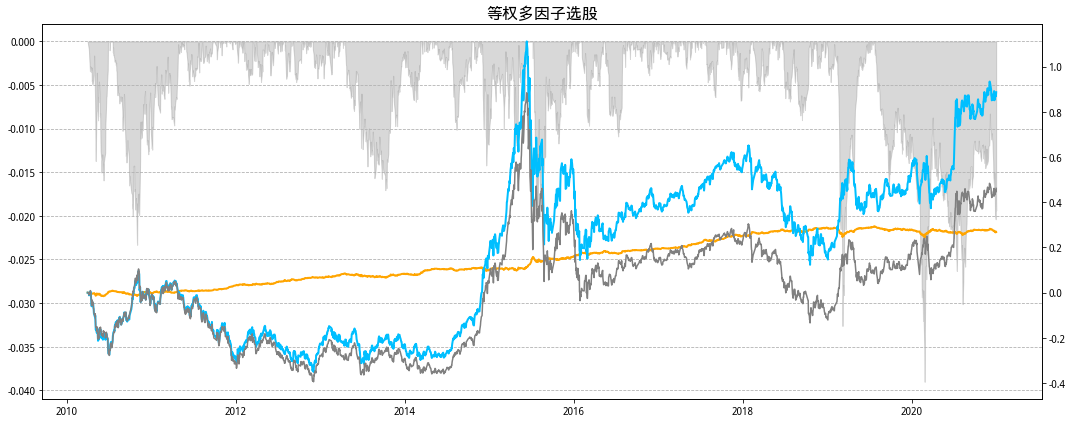

In [9]:
nav_df = easy_backtest_indexenhancement(eq_factor,
                       eq_factor,
                        start_date=start_date, 
                        end_date=end_date,
                        daily_returns = daily_returns,
                        group=10, 
                    )

NA = net_value_analysis(nav_excess_df=nav_df)
NA.plot_hedging(title='等权多因子选股')
NA.cal_indicators()

In [10]:
underwater(NA.nav_excess_df, start_date, end_date)

,数据
最大回撤开始日期,2019年07月22日
最大回撤结束日期,2020年02月25日
最大回撤幅度,-3.90%


In [11]:
NA.win_prob()

,win_prob
日度,53.18%
周度,57.85%
月度,63.28%
年度,72.73%


,strategy,benchmark,hedging
year,,,
2010,-0.23,0.05,-0.28
2011,-29.02,-31.59,2.57
2012,9.61,5.97,3.64
2013,-0.04,-1.65,1.61
2014,57.65,54.69,2.96
2015,16.40,9.95,6.45
2016,-2.17,-4.97,2.80
2017,13.47,8.13,5.34
2018,-26.69,-28.73,2.04


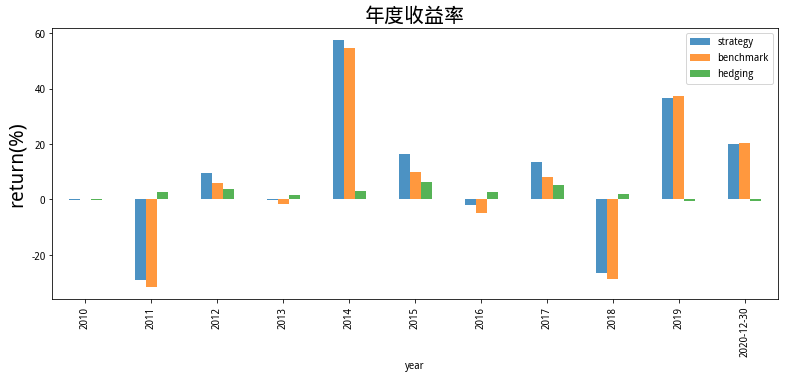

In [12]:
NA.plot_ret()

In [13]:
monthly_return = get_monthly_return(univ, trade_month_list)
hs300_factor, hs300_weight = ICIR_weight(fac_dict, monthly_return, 12)

,strategy,benchmark
年化收益率,10.53%,6.63%
年化标准差,23.07%,24.15%
贝塔,0.95,1
夏普比率,0.46,0.27
信息比率,1.35,0
最大回撤,43.71%,54.03%


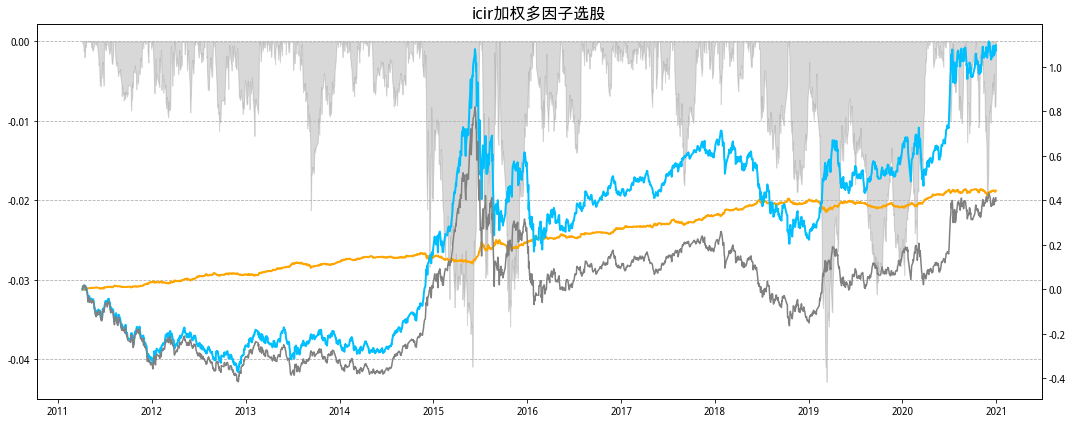

In [14]:
start_date = '2011-01-01'
nav_df = easy_backtest_indexenhancement(hs300_factor, 
                       hs300_factor,
                        start_date=start_date, 
                        end_date=end_date,
                        daily_returns=daily_returns,
                        group=5, 
                    )

NA = net_value_analysis(nav_excess_df=nav_df)
NA.plot_hedging(title='icir加权多因子选股')
NA.cal_indicators()

In [15]:
underwater(NA.nav_excess_df, start_date, end_date)

,数据
最大回撤开始日期,2018年10月16日
最大回撤结束日期,2019年03月12日
最大回撤幅度,-4.28%


In [16]:
NA.win_prob()

,win_prob
日度,54.01%
周度,57.59%
月度,63.79%
年度,90.0%


,strategy,benchmark,hedging
year,,,
2011,-31.73,-33.95,2.22
2012,9.43,5.97,3.46
2013,4.01,-1.65,5.65
2014,58.45,54.69,3.77
2015,17.32,9.95,7.37
2016,0.01,-4.97,4.98
2017,13.43,8.13,5.30
2018,-24.95,-28.73,3.78
2019,35.07,37.38,-2.31


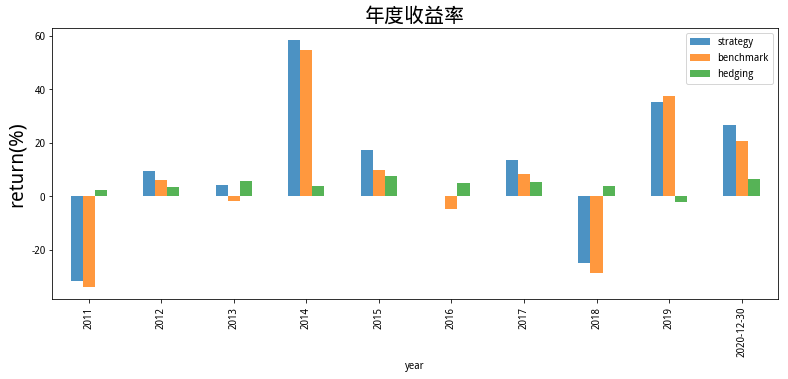

In [17]:
NA.plot_ret()

In [23]:
start_date = '2010-01-01'
eq_factor2 = equal_weight(fac_dict2)
daily_returns = get_daily_return(univ, start_date, end_date)
daily_returns.index = pd.to_datetime(daily_returns.index)

,strategy,benchmark
年化收益率,8.32%,6.69%
年化标准差,24.13%,24.39%
贝塔,0.99,1
夏普比率,0.35,0.27
信息比率,0.91,0
最大回撤,49.28%,54.03%


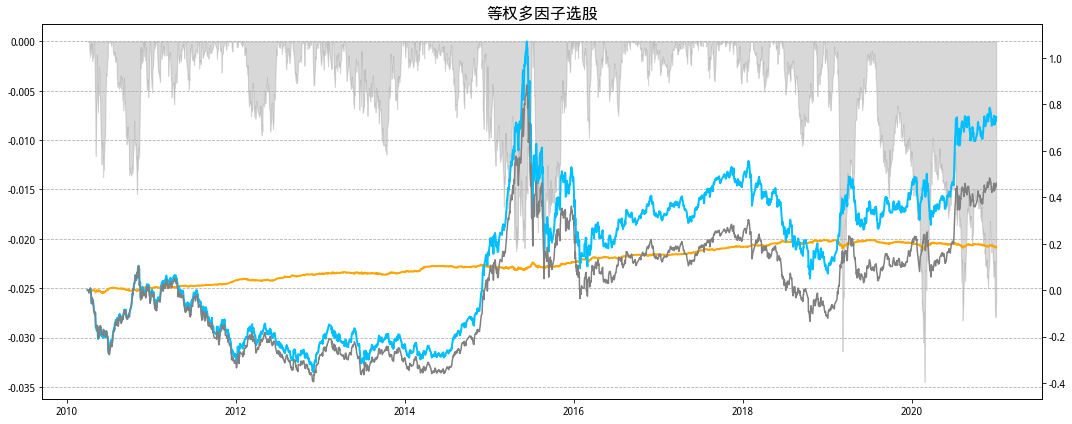

In [24]:
nav_df = easy_backtest_indexenhancement(eq_factor2,
                       eq_factor2,
                        start_date=start_date, 
                        end_date=end_date,
                        daily_returns = daily_returns,
                        group=10, 
                    )

NA = net_value_analysis(nav_excess_df=nav_df)
NA.plot_hedging(title='等权多因子选股')
NA.cal_indicators()

In [25]:
underwater(NA.nav_excess_df, start_date, end_date)

,数据
最大回撤开始日期,2018年12月19日
最大回撤结束日期,2020年02月25日
最大回撤幅度,-3.45%


In [26]:
NA.win_prob()

,win_prob
日度,53.33%
周度,55.36%
月度,62.5%
年度,81.82%


,strategy,benchmark,hedging
year,,,
2010,0.84,0.05,0.79
2011,-29.17,-31.59,2.41
2012,8.80,5.97,2.83
2013,-0.70,-1.65,0.95
2014,57.98,54.69,3.29
2015,12.14,9.95,2.19
2016,-2.21,-4.97,2.76
2017,11.26,8.13,3.13
2018,-27.12,-28.73,1.61


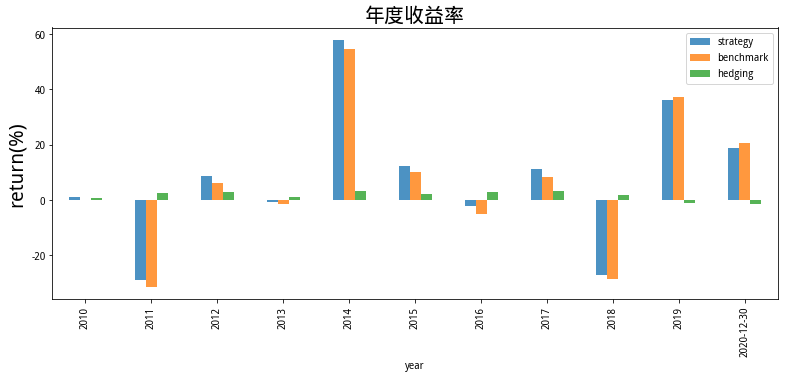

In [27]:
NA.plot_ret()

In [28]:
monthly_return = get_monthly_return(univ, trade_month_list)
hs300_factor2, hs300_weight2 = ICIR_weight(fac_dict2, monthly_return, 12)

,strategy,benchmark
年化收益率,9.64%,6.63%
年化标准差,23.78%,24.15%
贝塔,0.98,1
夏普比率,0.41,0.27
信息比率,1.13,0
最大回撤,46.19%,54.03%


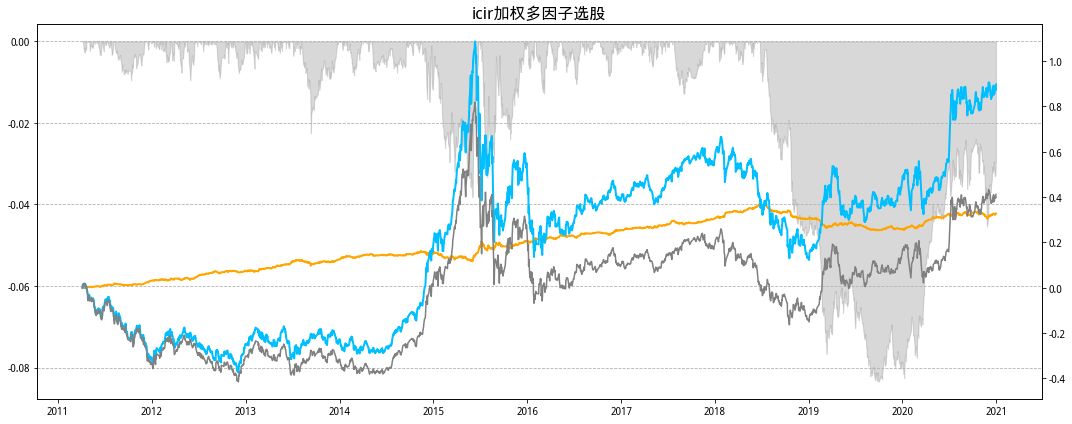

In [29]:
start_date = '2011-01-01'
nav_df = easy_backtest_indexenhancement(hs300_factor2, 
                       hs300_factor2,
                        start_date=start_date, 
                        end_date=end_date,
                        daily_returns=daily_returns,
                        group=5, 
                    )

NA = net_value_analysis(nav_excess_df=nav_df)
NA.plot_hedging(title='icir加权多因子选股')
NA.cal_indicators()

In [30]:
underwater(NA.nav_excess_df, start_date, end_date)

,数据
最大回撤开始日期,2018年06月22日
最大回撤结束日期,2019年09月30日
最大回撤幅度,-8.35%


In [31]:
NA.win_prob()

,win_prob
日度,53.2%
周度,57.17%
月度,62.07%
年度,80.0%


,strategy,benchmark,hedging
year,,,
2011,-31.93,-33.95,2.02
2012,10.32,5.97,4.35
2013,3.37,-1.65,5.02
2014,59.10,54.69,4.41
2015,15.14,9.95,5.19
2016,-1.00,-4.97,3.96
2017,12.62,8.13,4.50
2018,-28.82,-28.73,-0.09
2019,32.91,37.38,-4.47


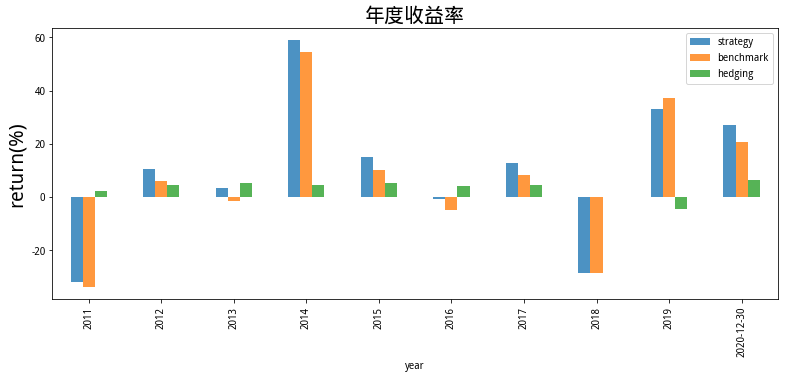

In [32]:
NA.plot_ret()

In [6]:
fac_dict3 = { '经营活动产生的现金流量净额与企业价值之比TTM':cfo_to_ev,
                     '残差波动率':residual_volatility, 
                     '个股收益的60日偏度':Skewness60,  
                     '权益回报率TTM':roe_ttm, 
                     '个股收益的20日偏度':Skewness20, 
                     '销售毛利率':gross_income_ratio, 
                     '市盈率（TTM）':pe_ratio, 
                     '市净率（TTM）':pb_ratio,
                     '单季度营业收入增长率（同比）':inc_revenue_year_on_year, 
                     '单季度净利润增长率（同比）':inc_net_profit_year_on_year,
                     '单季度营业利润增长率（同比）':inc_operation_profit_year_on_year, 
                     '营业费用与营业总收入之比':sale_expense_to_operating_revenue,
                    }

In [9]:
start_date = '2010-01-01'
eq_factor3 = equal_weight(fac_dict3)
daily_returns = get_daily_return(univ, start_date, end_date)
daily_returns.index = pd.to_datetime(daily_returns.index)

In [ ]:
nav_df = easy_backtest_indexenhancement(eq_factor3,
                       eq_factor3,
                        start_date=start_date, 
                        end_date=end_date,
                        daily_returns = daily_returns,
                        group=10, 
                    )

NA = net_value_analysis(nav_excess_df=nav_df)
NA.plot_hedging(title='等权多因子选股')
NA.cal_indicators()

In [ ]:
underwater(NA.nav_excess_df, start_date, end_date)

In [ ]:
NA.win_prob()

In [ ]:
NA.plot_ret()

In [14]:
def get_positions(factor, start_date, end_date, group=5, freq='M'):
    """
    获取持仓
    params：
        factor：dataframe，index为date，columns为code，values为因子值
        start_date：开始时间
        end_date：结束时间
        group：第几组作为持仓组合
        freq：调仓频率，默认月频，根据因子频率来设定
    return：
        nav_df：策略和基准的净值数据
    """
    rebalance_dates = get_period_date(freq, start_date, end_date)
    rebalance_dates = [datetime.strptime(dt, '%Y-%m-%d') for dt in rebalance_dates]
    factor.index = pd.to_datetime(factor.index)
    factor = factor.stack().dropna()
    factor.name = 'factor'
    
    quantile_groups = bucketize_by_quantile(factor, group)
    portfolio_weights = get_portfolios_from_quantile_groups(quantile_groups, 1)
    
    cum_list = []
    for start in rebalance_dates:
        weights = portfolio_weights[start]
        dat = [start]*len(weights)
        weights = pd.DataFrame(weights)
        weights['date'] = dat
        weights = weights.reset_index()
        weights.columns = ['code', 'factor', 'date']
        cum_list.append(weights)
        
    cum_df = pd.concat(cum_list)
    cum_df = cum_df.reset_index().drop(['index'], axis=1)
    
    factors = []
    names = []
    
    for dat, cod in zip(cum_df.date, cum_df.code):
        factors.append(factor.loc[dat, cod])
        name = get_all_securities(date=dat)[['display_name']]
        names.append(name.display_name[cod])
    cum_df.factor = factors
    cum_df['name'] = names
    
    cum_df = cum_df.set_index(['date', 'code'])
    return cum_df

In [15]:
all_position = get_positions(eq_factor3, start_date, '2020-11-30', group=10, freq='M')
file = 'icir_hs300.csv'
all_position.to_csv(file)

In [16]:
def get_latest_position(file, last_date=True, date='2020-01-23', num=50):
    """
    获取某一期的持仓
    param：
        file：持仓文件
        last_date：日期是否最新
        date：持仓日期
        num：持股数目
    return：
        某一期的持仓
    """
    position = pd.read_csv(file, index_col='date')
    
    date = position.index[-1]
    position = position.loc[date].nlargest(num,'factor')
    
    return position

In [17]:
get_latest_position(file, num=100)

,code,factor,name
date,,,
2020-11-30,000651.XSHE,-5.377368,格力电器
2020-11-30,601808.XSHG,-5.653977,中海油服
2020-11-30,601018.XSHG,-5.735195,宁波港
2020-11-30,601698.XSHG,-5.770164,中国卫通
2020-11-30,000977.XSHE,-5.988774,浪潮信息
2020-11-30,002024.XSHE,-6.034965,苏宁易购
2020-11-30,601633.XSHG,-6.081458,长城汽车
2020-11-30,600660.XSHG,-6.086885,福耀玻璃
2020-11-30,002153.XSHE,-6.167274,石基信息
